In [1]:
%load_ext autoreload
%autoreload 2

In [120]:
from fsd_path_planning.demo.streamlit_demo.common import get_cones_for_configuration
import numpy as np
import matplotlib.pyplot as plt
from fsd_path_planning.utils.math_utils import rotate, angle_from_2d_vector
from numpy import array, float64

In [121]:
# position, direction, cones = get_cones_for_configuration("Hairpin Extreme", do_shuffle=True)

# position = np.array([36, 30.0])
# direction = np.array([1, 1.0])
# direction = direction / np.linalg.norm(direction)

from pathlib import Path
position, direction, cones = eval(Path('/home/papalotis/repos/fsd-path-planning/test.txt').read_text())

cones = [np.array(cone).reshape(-1,2) for cone in cones]

In [122]:
cones_together = np.row_stack(cones)

idxs = np.random.default_rng(0).random(len(cones_together)).argsort()


cones_together = cones_together[idxs]

(-1.7167541499999999, 3.02699585, -0.9562774656855602, 20.08081969931836)

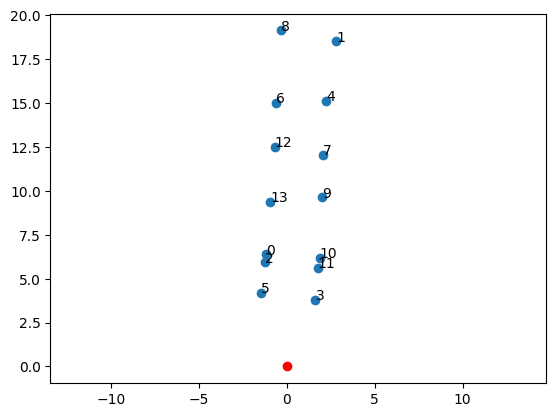

In [123]:

mask_keep = np.ones(len(cones_together), dtype=bool)
# mask_keep[1] = False

cones_together = cones_together[mask_keep]
plt.plot(*cones_together.T, "o")
plt.plot(*position, "ro")
for i, (x,y) in enumerate(cones_together):
    plt.text(x, y, str(i))

plt.axis("equal")

In [124]:
from fsd_path_planning.sorting_cones.trace_sorter.core_trace_sorter import TraceSorter
from fsd_path_planning.utils.cone_types import ConeTypes

In [125]:
ts_kwargs = dict(
    max_n_neighbors=5, max_dist=5.0, max_dist_to_first=6.0, max_length=10, threshold_directional_angle=np.deg2rad(40), threshold_absolute_angle=np.deg2rad(55)
)

ts = TraceSorter(**ts_kwargs)

In [126]:
print(ts.select_first_two_starting_cones(position, direction, cones_together, ConeTypes.RIGHT))
print(ts.select_first_two_starting_cones(position, direction, cones_together, ConeTypes.LEFT))

7.800000000000001
7.800000000000001
[ 3 11]
7.800000000000001
7.800000000000001
[5]


7.800000000000001
7.800000000000001
7.800000000000001
7.800000000000001


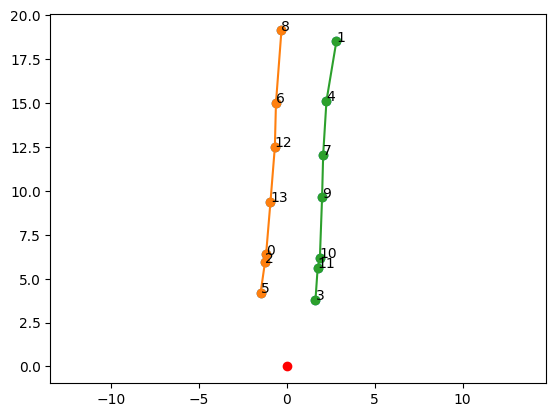

In [127]:
out_left = ts.sort(cones_together, ConeTypes.LEFT, position, direction)
out_right = ts.sort(cones_together, ConeTypes.RIGHT, position, direction)
if out_left is not None:
    left_best_score, left_best_config = out_left[0][0], out_left[1][0]
else:
    left_best_score, left_best_config = [],np.zeros(len(cones_together), dtype=int) - 1

if out_right is not None:
    right_best_score, right_best_config = out_right[0][0], out_right[1][0]
else:
    right_best_score, right_best_config = [], np.zeros(len(cones_together), dtype=int) - 1

left_best_config = left_best_config[left_best_config != -1]
right_best_config = right_best_config[right_best_config != -1]

plt.plot(*cones_together.T, "o")
plt.plot(*position, "ro")

plt.plot(*cones_together[left_best_config].T, "o-")
plt.plot(*cones_together[right_best_config].T, "o-")
plt.axis("equal")

for i, (x,y) in enumerate(cones_together):
    plt.text(x, y, str(i))


In [128]:
from typing import Optional

from itertools import product
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import cost_configurations

from fsd_path_planning.sorting_cones.trace_sorter.line_segment_intersection import pairwise_segment_intersection, number_of_intersections, lines_segments_intersect_indicator


def n_intersections(trace_left, trace_right):
    if len(trace_left) == 1 or len(trace_right) == 1:
        n = 0
    else:
        starts = np.row_stack([trace_left[:-1], trace_right[:-1]])
        ends = np.row_stack([trace_left[1:], trace_right[1:]])

        n_intersections_ignore = len(trace_left) - 2 + len(trace_right) - 2
        raw_intersections = pairwise_segment_intersection(starts, ends)

        n = number_of_intersections(raw_intersections) - n_intersections_ignore
    return n



def find_first_intersection_in_trace(trace: np.ndarray, other_trace: np.ndarray) -> Optional[int]:
    for i in range(len(trace) - 1):
        for j in range(len(other_trace) - 1):
            start_1 = trace[i]
            end_1 = trace[i + 1]
            start_2 = other_trace[j]
            end_2 = other_trace[j + 1]

            if lines_segments_intersect_indicator(start_1, end_1, start_2, end_2):
                return i
        
    return None

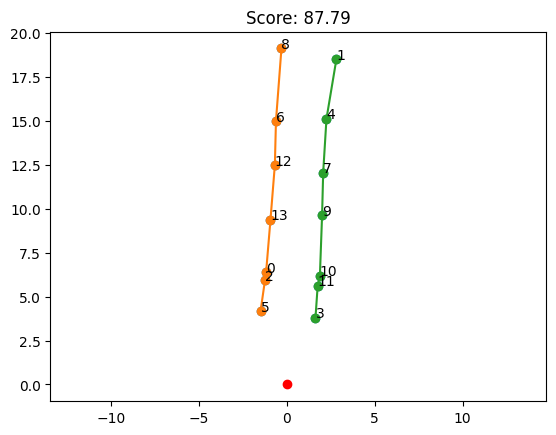

In [135]:
from itertools import chain
from fsd_path_planning.utils.math_utils import vec_angle_between



def colorless_sort(cones: np.ndarray, position: np.ndarray, direction: np.ndarray) -> tuple[np.ndarray, np.ndarray, float]:
    # old_print = print
    print = lambda *args, **kwargs: None

    empty_result = np.zeros((0,2)), np.zeros((0,2)), -1

    all_left = ts.sort(cones, ConeTypes.LEFT, position, direction)
    all_right = ts.sort(cones, ConeTypes.RIGHT, position, direction)

    n_traces_unsorted = sum(x is None for x in [all_left, all_right])

    if n_traces_unsorted == 1:
        return handle_only_one_side_sorted(cones, all_left, all_right)
    elif n_traces_unsorted == 2:
        # both sides are unsorted, so we can't do anything
        return empty_result
    
    left_scores, left_configs = all_left
    right_scores, right_configs = all_right

    left_zip = zip(left_scores, left_configs)
    right_zip = zip(right_scores, right_configs)

    it = list(product(left_zip, right_zip))
    scores = []
    configs = []

    for i,x in enumerate(it):
        (left_score, left_config), (right_score, right_config) = x

        left_config = left_config[left_config != -1]
        right_config = right_config[right_config != -1]

        original_left_config = left_config.copy()
        original_right_config = right_config.copy()
        
    
        
        
        left_config, right_config, left_trace, right_trace = handle_same_cone_in_both_configs(cones, position, direction, print, left_config, right_config)

        left_score, left_config, right_score, right_config = handle_edge_intersection_between_both_configs(cones, position, direction, print, left_config, right_config, left_trace, right_trace, left_score, right_score)
            

        score = left_score + right_score

        scores.append(score)
        configs.append((left_config, right_config))

        # if the indepedent sorting of the two sides does not result in any intersection
        # we use this result directly. it is assumed that configs are sorted by score
        if i == 0 and config_has_not_changed(left_config, right_config, original_left_config, original_right_config):
            break

    if len(scores) == 0:
        # no valid combination found
        return empty_result
    

    best_score_idx = np.argmin(scores)
    best_score = scores[best_score_idx]
    if best_score == np.inf:
        return empty_result


    best_combination = configs[best_score_idx]
    best_left, best_right = best_combination
    best_left_points = cones[best_left[best_left != -1]]
    best_right_points = cones[best_right[best_right != -1]]

    return best_left_points, best_right_points, best_score

def config_has_not_changed(left_config, right_config, orig_left_config, orig_right_config):
    len(left_config) == len(orig_left_config) and np.allclose(orig_left_config, left_config) and len(right_config) == len(orig_right_config) and np.allclose(orig_right_config, right_config)

def handle_only_one_side_sorted(cones, all_left, all_right):
    side_not_none = ConeTypes.LEFT if all_left is not None else ConeTypes.RIGHT
    non_none_result = all_left if all_left is not None else all_right
    _, configs = non_none_result
    best_config = configs[0]
    best_config = best_config[best_config != -1]
    best_trace = cones[best_config]

    best_left_points, best_right_points, best_score = (best_trace, np.zeros((0, 2)), -1) if side_not_none == ConeTypes.LEFT else (np.zeros((0,2)), best_trace, -1)

    return best_left_points, best_right_points, best_score

def handle_edge_intersection_between_both_configs(cones, position, direction, print, left_config, right_config, left_trace, right_trace, left_score, right_score):
    edges_intersections = n_intersections(left_trace, right_trace)
    if edges_intersections > 0:
        stop_left = find_first_intersection_in_trace(left_trace, right_trace)
        stop_right = find_first_intersection_in_trace(right_trace, left_trace)

        left_config = left_config[:stop_left]
        right_config = right_config[:stop_right]

        if len(left_config) > 2 and len(right_config) > 2:
            left_score = cost_configurations(cones, left_config[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)[0]
            right_score = cost_configurations(cones, right_config[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)[0]
        else:
            left_score = float("inf")
            right_score = float("inf")
    return left_score,left_config,right_score,right_config

def handle_same_cone_in_both_configs(cones, position, direction, print, left_config, right_config):
    same_cone_intersection, left_intersection_idxs, right_intersection_idxs = np.intersect1d(left_config, right_config, return_indices=True)
    if len(same_cone_intersection) > 0 and len(left_config) >= 3 and len(right_config) >= 3:
        print('cone_intersection')
        left_stop_idx = min(left_intersection_idxs)
        right_stop_idx = min(right_intersection_idxs)

        if left_config[left_stop_idx] == right_config[right_stop_idx] and left_stop_idx > 0 and right_stop_idx > 0 and left_stop_idx < len(left_config) - 1 and right_stop_idx < len(right_config) - 1:
            intersection = cones[left_config[[left_stop_idx]]]
            prev_left = cones[left_config[left_stop_idx - 1]]
            prev_right = cones[right_config[right_stop_idx - 1]]
            next_left = cones[left_config[left_stop_idx + 1]]
            next_right = cones[right_config[right_stop_idx + 1]]

            intersection_to_next_right = next_right - intersection
            intersection_to_next_left = next_left - intersection

            intersection_to_prev_right = prev_right - intersection
            intersection_to_prev_left = prev_left - intersection

            angle_left = vec_angle_between(intersection_to_prev_left, intersection_to_next_left)
            angle_right = vec_angle_between(intersection_to_prev_right, intersection_to_next_right)

            if angle_left > angle_right:
                new_left_stop_idx = len(left_config)
                new_right_stop_idx = right_stop_idx
            else:
                new_left_stop_idx = left_stop_idx
                new_right_stop_idx = len(right_config)
        else:
            if left_stop_idx == len(left_config) - 1:
                new_right_stop_idx = len(right_config)
            else:
                new_right_stop_idx = right_stop_idx

            if right_stop_idx == len(right_config) - 1:
                new_left_stop_idx = len(left_config)
            else:
                new_left_stop_idx = left_stop_idx

        left_config = left_config[:new_left_stop_idx]
        right_config = right_config[:new_right_stop_idx]

        new_n_left = len(left_config)
        new_n_right = len(right_config)
        print("new_n_left", new_n_left)
        print("new_n_right", new_n_right)
        if new_n_left < 3 and new_n_right < 3:
            left_score = float("inf")
            right_score = float("inf")
        elif new_n_left < 3:
            right_score = cost_configurations(cones, right_config[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)[0]
            left_score = right_score
        elif new_n_right < 3:
            left_score = cost_configurations(cones, left_config[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)[0]
            right_score = left_score
        else:
            left_score = cost_configurations(cones, left_config[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)[0]
            right_score = cost_configurations(cones, right_config[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)[0]


    left_trace = cones[left_config]
    right_trace = cones[right_config]
    return left_config,right_config,left_trace,right_trace


left, right, score = colorless_sort(cones_together, position, direction)

if left is not None:
    plt.plot(*cones_together.T, "o")
    plt.plot(*position, "ro")
    plt.plot(*left.T, "o-")
    plt.plot(*right.T, "o-")
    plt.title(f"Score: {score:.2f}")
    plt.axis("equal")
    for c in chain(left, right):
        idx = np.linalg.norm(c - cones_together, axis=1).argmin()
        plt.text(*c, idx)
else:
    print("No solution found")

(-1.7167541499999999, 3.02699585, -1.1850603330726013, 24.885259914446223)

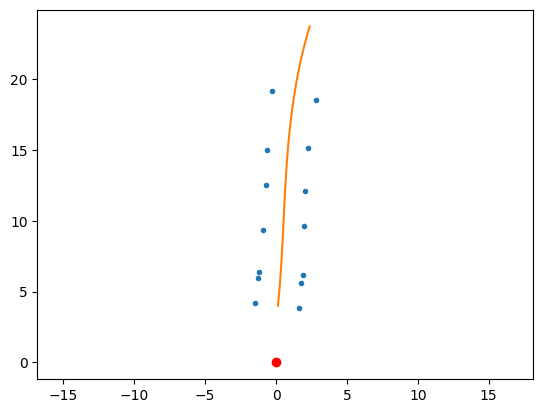

In [136]:
from fsd_path_planning.calculate_path.core_calculate_path import PathCalculationInput
from fsd_path_planning.cone_matching.core_cone_matching import ConeMatchingInput
from fsd_path_planning.config import (
    create_default_cone_matching,
    create_default_pathing,
)

from fsd_path_planning.types import FloatArray
from fsd_path_planning.utils.cone_types import ConeTypes
from fsd_path_planning.utils.mission_types import MissionTypes

mission = MissionTypes.trackdrive

def calc_path(left_sorted, right_sorted, position, direction):


    cone_matching = create_default_cone_matching(mission)
    pathing = create_default_pathing(mission)
    cones_for_matching = [np.zeros((0, 2)) for _ in ConeTypes]
    cones_for_matching[ConeTypes.LEFT] = left_sorted
    cones_for_matching[ConeTypes.RIGHT] = right_sorted

    cone_matching_input = ConeMatchingInput(
        cones_for_matching, position, direction
    )
    cone_matching.set_new_input(cone_matching_input)

    (
        left_cones_with_virtual,
        right_cones_with_virtual,
        left_to_right_match,
        right_to_left_match,
    ) = cone_matching.run_cone_matching()

    path_calculation_input = PathCalculationInput(
        left_cones_with_virtual,
        right_cones_with_virtual,
        left_to_right_match,
        right_to_left_match,
        position,
        direction,
    )
    pathing.set_new_input(path_calculation_input)
    final_path, _ = pathing.run_path_calculation()

    return final_path

final_path = calc_path(left, right, position, direction)

plt.plot(*cones_together.T, "o", ms=3)
plt.plot(*position.T, "ro")
plt.plot(final_path[:,1], final_path[:,2], "-")

plt.axis("equal")


In [133]:
from fsd_path_planning.demo.json_demo import load_data_json
from tqdm import tqdm

demo_positions, demo_directions, demo_cones = load_data_json(Path('/home/papalotis/repos/fsd-path-planning/fsd_path_planning/demo/fss_19_4_laps.json'))
# demo_positions, demo_directions, demo_cones = load_data_json()

it = list(enumerate(zip(demo_positions, demo_directions, demo_cones)))


low_pass_path = None


for i, (demo_positions_i, demo_directions_i, demo_cones_i) in tqdm(it[:800]):

    demo_cones_i = [np.array(cones_of_type).reshape(-1,2) for cones_of_type in demo_cones_i]
    cones_together_i = np.row_stack(demo_cones_i)
    try:
        result = colorless_sort(cones_together_i, demo_positions_i, demo_directions_i)
    except:
        print(i)
        raise
    
    
    left_cones, right_cones, score = result
    left_cones = left_cones[:-1]
    right_cones = right_cones[:-1]
    try:
        path = calc_path(left_cones, right_cones, demo_positions_i, demo_directions_i)

        path_xy = path[:,1:3]
    except ValueError:
        path_xy = low_pass_path

    if low_pass_path is not None:
        low_pass_path = low_pass_path * 0.2 + path_xy * 0.8
    else:
        low_pass_path = path_xy


    plt.plot(*cones_together_i.T, "o", ms=3)
    plt.plot(*demo_positions_i, "ro")
    
    plt.plot(*left_cones.T, "o-", label="left", ms=3)
    plt.plot(*right_cones.T, "o-", label="right", ms=3)

    plt.plot(*low_pass_path.T, "-", label="path")
    plt.axis("equal")
    plt.title(f"{i}")
    plt.savefig(f"frames/frame_{i:04d}.png")
    plt.close()

#     # plt.show()

 90%|█████████ | 722/800 [03:12<00:31,  2.47it/s]

0.2 0.1 3 array([[8.38292286, 3.37265973],
       [8.41803521, 3.27902681],
       [8.45314755, 3.18539389],
       [8.48825989, 3.09176097],
       [8.52337224, 2.99812805],
       [8.55848458, 2.90449514],
       [8.59359693, 2.81086222],
       [8.62870927, 2.7172293 ],
       [8.66382161, 2.62359638],
       [8.69893396, 2.52996347],
       [8.7340463 , 2.43633055],
       [8.76915865, 2.34269763],
       [8.80427099, 2.24906471],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],
       [8.83938334, 2.15543179],


100%|██████████| 800/800 [03:35<00:00,  3.72it/s]


7.800000000000001


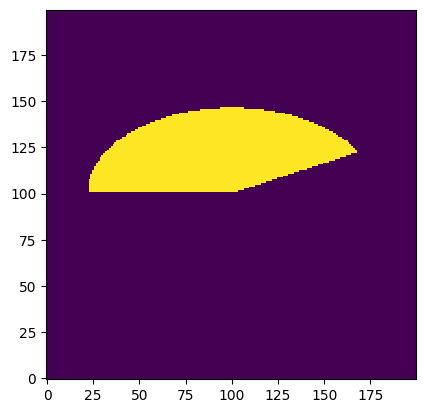

In [118]:
pos = np.array([0, 0])
dir = np.array([1, 0])

points = np.mgrid[-10:10:0.1, -10:10:0.1].reshape(2, -1).T

_, m = ts.mask_cone_can_be_first_in_config(pos, dir, points, ConeTypes.LEFT)
n = int(len(m) ** 0.5)

plt.imshow(m.reshape(n, n).T, origin="lower", interpolation='nearest')
# plt.plot(*points.T, "o")
# plt.axis("equal")
# plt.show()

# points_relative = rotate(points - pos, -angle_from_2d_vector(dir))
# plt.plot(*points_relative.T, "o")
# plt.axis("equal")
# plt.scatter(*points.T, c=m, cmap="viridis")

In [119]:
x=str(repr(it[0][1]))
Path("test.txt").write_text(x)

626